# Import Required Libraries

In [1]:
!pip install contractions
!pip install --upgrade imbalanced-learn scikit-learn
!pip install shap
!pip install spacy

!python -m spacy download en_core_web_sm
!pip install tensorflow
!pip install textblob
!pip install textstat

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import numpy as np
import pandas as pd
import spacy
import string
from textblob import TextBlob
from collections import Counter
import textstat

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Data balancing
from imblearn.over_sampling import SMOTE

# Sklearn libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
)
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import tensorflow as tf

# NLTK libraries
import nltk
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer, word_tokenize
import contractions
from nltk.sentiment.vader import SentimentIntensityAnalyzer


import spacy
nlp = spacy.load("en_core_web_sm")


# NLTK resource downloads
nltk.download('words')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('vader_lexicon')



[nltk_data] Downloading package words to
[nltk_data]     /Users/sandhiyadhanasekaran/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sandhiyadhanasekaran/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sandhiyadhanasekaran/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sandhiyadhanasekaran/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sandhiyadhanasekaran/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Load in Datasets


In [3]:
def load_file(filepath):
    return pd.read_csv(filepath, header=None, names=['text'])

In [4]:

# Training df
df_train = load_file('raw_data/fulltrain.csv')
df_train['label'] = df_train.index

# Testing df
df_test = load_file('raw_data/balancedtest.csv')
df_test['label'] = df_test.index


# Map the labels

In [5]:
label_mapping = {
    1: "Satire",
    2: "Hoax",
    3: "Propaganda",
    4: "Reliable News"
}
df_train['label'] = df_train['label'].map(label_mapping)
df_test['label'] = df_test['label'].map(label_mapping)


# Verify datasets loaded in correctly

In [6]:

df_train.head(10) # Training set

,text,label
1,"A little less than a decade ago, hockey fans w...",Satire
1,The writers of the HBO series The Sopranos too...,Satire
1,Despite claims from the TV news outlet to offe...,Satire
1,After receiving 'subpar' service and experienc...,Satire
1,After watching his beloved Seattle Mariners pr...,Satire
1,"At a cafeteria-table press conference Monday, ...",Satire
1,Stunned shock and dismay were just a few of th...,Satire
1,"Speaking with reporters before a game Monday, ...",Satire
1,Sports journalists and television crews were p...,Satire
1,"SALEM, VAF;or the eighth straight world-histor...",Satire


In [7]:
df_test.head(10) # Test set

,text,label
1,When so many actors seem content to churn out ...,Satire
1,In what football insiders are calling an unex...,Satire
1,In a freak accident following Game 3 of the N....,Satire
1,North Koreas official news agency announced to...,Satire
1,The former Alaska Governor Sarah Palin would b...,Satire
1,With the first Presidential debate just two da...,Satire
1,"There are fans, and then there are super-fans....",Satire
1,"With its landmark decisions this week, the Uni...",Satire
1,Koch Industries is defending its acquisition o...,Satire
1,Republican lawmakers asked increasingly tough ...,Satire


# Label distribution

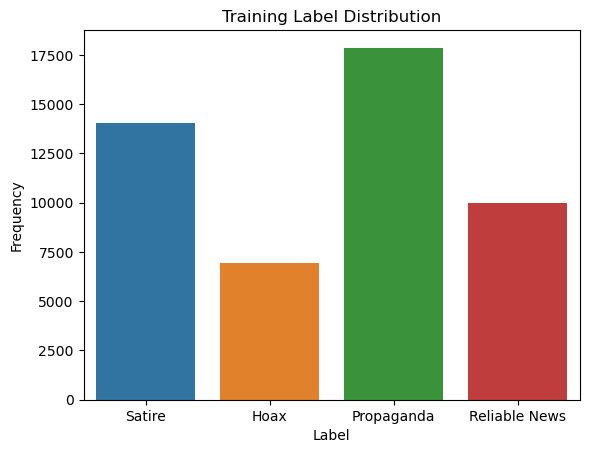

Propaganda       17870
Satire           14047
Reliable News     9995
Hoax              6942
Name: label, dtype: int64

In [8]:
sns.countplot(x='label', data=df_train)
plt.title('Training Label Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()
df_train["label"].value_counts()

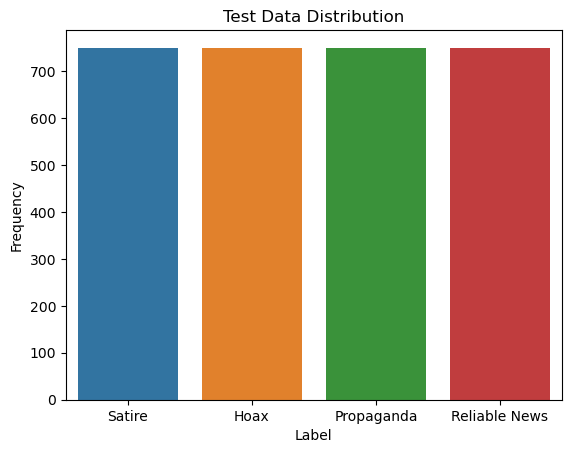

Satire           750
Hoax             750
Propaganda       750
Reliable News    750
Name: label, dtype: int64

In [9]:
sns.countplot(x='label', data=df_test)
plt.title('Test Data Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()
df_test["label"].value_counts()

# Basic Text Preprocessing

## Expand Contractions

In [10]:
def expand_contractions(corpus):
    return contractions.fix(corpus)

## Removal of Stop Words

In [11]:
def remove_stopwords(corpus):
    stop = nltk.corpus.stopwords.words('english')
    sentence = ""
    for word in corpus.split():
        if word not in stop:
            sentence += word
            sentence += " "
    return sentence.strip()

## Lemmitization with WordNetLemmitizer

In [12]:
def lemmatize_word(corpus):
    lemma = WordNetLemmatizer()
    sentence = ""
    for word in corpus.split():
        sentence += lemma.lemmatize(word)
        sentence += " "
    return sentence.strip()

## Preprocess the text

In [13]:
def preprocess_text(text):
    text_contractions_expanded = expand_contractions(text)
    text_no_stopwords = remove_stopwords(text_contractions_expanded)
    text_processed = lemmatize_word(text_no_stopwords)
    return text_processed

In [14]:
# Processing datasets
print("Processing dataset: df_train")
df_train['processed_text'] = df_train['text'].apply(preprocess_text)
print("Finished processing dataset: df_train")

print("Processing dataset: df_test")
df_test['processed_text'] = df_test['text'].apply(preprocess_text)
print("Finished processing dataset: df_test")

Processing dataset: df_train
Finished processing dataset: df_train
Processing dataset: df_test
Finished processing dataset: df_test


## Vectorizer- tfidf


In [16]:
#Add sentiment scores and text lengths as additional features
sid = SentimentIntensityAnalyzer()
df_train['sentiment_score'] = df_train['processed_text'].apply(lambda text: sid.polarity_scores(text)['compound'])
df_train['sentiment_score'] = df_train['sentiment_score'].astype(str)

# # Concatenate features for vectorization
X_train_features = df_train['processed_text'] + ' '+ df_train['sentiment_score']

In [17]:
# Initialize TF-IDF vectorizer with desired parameters
tfidf_vectorizer = TfidfVectorizer(max_features=10000)

X_train_counts = tfidf_vectorizer.fit_transform(X_train_features)


pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_counts.toarray())


smote = SMOTE(random_state=42)
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train_pca, df_train['label'])

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val= train_test_split(X_train_oversampled, y_train_oversampled, test_size=0.2, random_state=42)


# simple neural network

In [18]:
# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Build a simple feedforward neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')  # Assuming 4 classes for classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the neural network
model.fit(X_train, y_train_encoded, epochs=30, batch_size=32, validation_split=0.2)


y_train_pred = np.argmax(model.predict(X_train), axis=1)
# y_test_pred = np.argmax(model.predict(X_test_processed), axis=1)

# Calculate accuracy for training and test datasets
train_accuracy = accuracy_score(y_train_encoded, y_train_pred)
print("Train Accuracy:", train_accuracy)


Epoch 1/30


/Users/sandhiyadhanasekaran/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1430/1430 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8848 - loss: 0.3635 - val_accuracy: 0.9507 - val_loss: 0.1374
Epoch 2/30
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 1s 915us/step - accuracy: 0.9559 - loss: 0.1243 - val_accuracy: 0.9577 - val_loss: 0.1196
Epoch 3/30
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 1s 941us/step - accuracy: 0.9659 - loss: 0.0947 - val_accuracy: 0.9644 - val_loss: 0.1092
Epoch 4/30
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 1s 942us/step - accuracy: 0.9733 - loss: 0.0805 - val_accuracy: 0.9678 - val_loss: 0.0970
Epoch 5/30
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 1s 947us/step - accuracy: 0.9760 - loss: 0.0684 - val_accuracy: 0.9636 - val_loss: 0.1104
Epoch 6/30
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 1s 930us/step - accuracy: 0.9809 - loss: 0.0577 - val_accuracy: 0.9706 - val_loss: 0.0914
Epoch 7/30
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 1s 933us/step - accuracy: 0.9831 - loss: 0.0484 - val_accuracy: 0.9676 - val_loss: 0.1036
Epoch 8/30
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 1s 915us/step - accuracy: 0.9842 - loss: 0.0460

In [19]:
# # # snn Evaluate the model

# # Add sentiment scores and text lengths as additional features
sid = SentimentIntensityAnalyzer()
df_test['sentiment_score'] = df_test['processed_text'].apply(lambda text: sid.polarity_scores(text)['compound'])
df_test['sentiment_score'] = df_test['sentiment_score'].astype(str)

# # Concatenate features for vectorization
X_test_features = df_test['processed_text'] + ' '+ df_test['sentiment_score']

In [20]:
# Vectorize the text in the test dataset using the same vectorizer as used for training
X_test_vectorized = tfidf_vectorizer.transform(X_test_features)
X_test_pca = pca.transform(X_test_vectorized.toarray())

# Predict labels for the test dataset
y_test_pred =np.argmax(model.predict(X_test_pca),axis=1)

# Encode the actual labels in the test dataset
y_test_encoded = label_encoder.transform(df_test['label'])

# Calculate accuracy for the test dataset
test_accuracy = accuracy_score(y_test_encoded, y_test_pred)

print("Test Accuracy:", test_accuracy)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test Accuracy: 0.7416666666666667


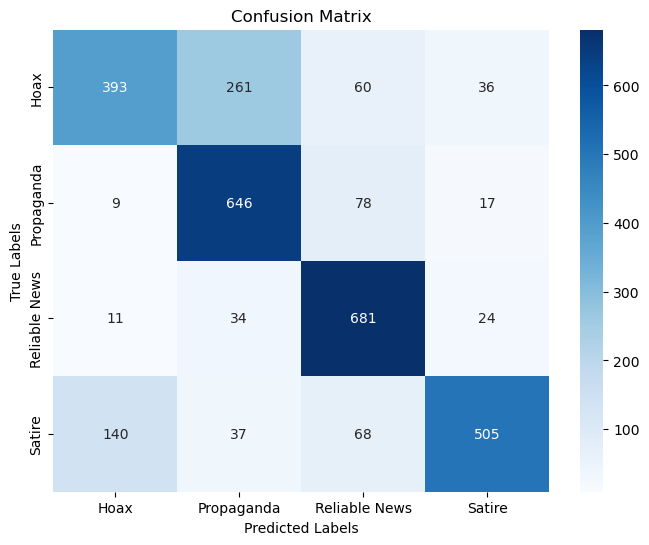

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_test_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [22]:
from sklearn.metrics import classification_report

# Calculate the classification report
report = classification_report(y_test_encoded, y_test_pred, target_names=label_encoder.classes_)

# Print the classification report
print("Classification Report:")
print(report)

Classification Report:
               precision    recall  f1-score   support

         Hoax       0.71      0.52      0.60       750
   Propaganda       0.66      0.86      0.75       750
Reliable News       0.77      0.91      0.83       750
       Satire       0.87      0.67      0.76       750

     accuracy                           0.74      3000
    macro avg       0.75      0.74      0.74      3000
 weighted avg       0.75      0.74      0.74      3000



# Cnn

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense

maxlen = 100  # Maximum sequence length
X_train_padded = pad_sequences(X_train, maxlen=maxlen, padding='post')


label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)



X_train_padded = X_train_padded.reshape(X_train_padded.shape[0], X_train_padded.shape[1], 1)


model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(128, 5, activation='relu', input_shape=(maxlen, 1)),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')  # Assuming 4 classes for classification
])


# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the neural network
model.fit(X_train, y_train_encoded, epochs=30, batch_size=32, validation_split=0.2)


y_train_pred = np.argmax(model.predict(X_train), axis=1)
# y_test_pred = np.argmax(model.predict(X_test_processed), axis=1)

# Calculate accuracy for training and test datasets
train_accuracy = accuracy_score(y_train_encoded, y_train_pred)
print("Train Accuracy:", train_accuracy)


Epoch 1/30


/Users/sandhiyadhanasekaran/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1430/1430 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.3927 - loss: 1.2757 - val_accuracy: 0.5374 - val_loss: 1.0817
Epoch 2/30
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.5704 - loss: 1.0265 - val_accuracy: 0.6716 - val_loss: 0.8413
Epoch 3/30
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.6607 - loss: 0.8444 - val_accuracy: 0.7262 - val_loss: 0.7272
Epoch 4/30
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.7209 - loss: 0.7182 - val_accuracy: 0.7741 - val_loss: 0.6181
Epoch 5/30
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.7653 - loss: 0.6209 - val_accuracy: 0.7570 - val_loss: 0.6398
Epoch 6/30
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.7888 - loss: 0.5629 - val_accuracy: 0.8097 - val_loss: 0.5223
Epoch 7/30
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.8112 - loss: 0.5035 - val_accuracy: 0.8277 - val_loss: 0.4646
Epoch 8/30
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8175 - loss: 0.4877 -

In [24]:
#cnnEvaluate the model

sid = SentimentIntensityAnalyzer()
df_test['sentiment_score'] = df_test['processed_text'].apply(lambda text: sid.polarity_scores(text)['compound'])
df_test['sentiment_score'] = df_test['sentiment_score'].astype(str)

# # Concatenate features for vectorization
X_test_features = df_test['processed_text'] + ' '+ df_test['sentiment_score']
# Vectorize the text in the test dataset using the same vectorizer as used for training
X_test_vectorized = tfidf_vectorizer.transform(X_test_features)
X_test_pca = pca.transform(X_test_vectorized.toarray())

# Predict labels for the test dataset
y_test_pred =np.argmax(model.predict(X_test_pca),axis=1)

# Encode the actual labels in the test dataset
y_test_encoded = label_encoder.transform(df_test['label'])

# Calculate accuracy for the test dataset
test_accuracy = accuracy_score(y_test_encoded, y_test_pred)

print("Test Accuracy:", test_accuracy)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test Accuracy: 0.6573333333333333


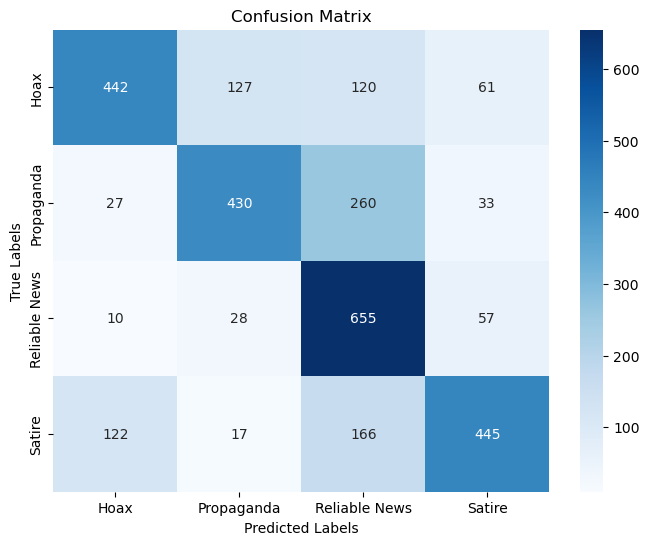

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_test_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# CNN-LSTM

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense

maxlen = 100  
X_train_padded = pad_sequences(X_train, maxlen=maxlen, padding='post')

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
 
X_train_padded = X_train_padded.reshape(X_train_padded.shape[0], X_train_padded.shape[1], 1)


model = Sequential()
model.add(Conv1D(128, 5, activation='relu', input_shape=(maxlen, 1)))
model.add(MaxPooling1D(2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(2))
model.add(LSTM(64))  
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))  

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the neural network
model.fit(X_train, y_train_encoded, epochs=30, batch_size=32, validation_split=0.2)


y_train_pred = np.argmax(model.predict(X_train), axis=1)

# Calculate accuracy for training and test datasets
train_accuracy = accuracy_score(y_train_encoded, y_train_pred)
print("Train Accuracy:", train_accuracy)


Epoch 1/30


/Users/sandhiyadhanasekaran/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1430/1430 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.4869 - loss: 1.0787 - val_accuracy: 0.7788 - val_loss: 0.6620
Epoch 2/30
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - accuracy: 0.8314 - loss: 0.4749 - val_accuracy: 0.8507 - val_loss: 0.4117
Epoch 3/30
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.8589 - loss: 0.3848 - val_accuracy: 0.8622 - val_loss: 0.3816
Epoch 4/30
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.8715 - loss: 0.3516 - val_accuracy: 0.8617 - val_loss: 0.3985
Epoch 5/30
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.8806 - loss: 0.3292 - val_accuracy: 0.8606 - val_loss: 0.3803
Epoch 6/30
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.8877 - loss: 0.3062 - val_accuracy: 0.8969 - val_loss: 0.2899
Epoch 7/30
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.8939 - loss: 0.2848 - val_accuracy: 0.8929 - val_loss: 0.2966
Epoch 8/30
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.8969 - loss: 0.28

In [31]:
# cnnlstm Evaluate the model

sid = SentimentIntensityAnalyzer()
df_test['sentiment_score'] = df_test['processed_text'].apply(lambda text: sid.polarity_scores(text)['compound'])
df_test['sentiment_score'] = df_test['sentiment_score'].astype(str)

X_test_features = df_test['processed_text'] + ' '+ df_test['sentiment_score']



X_test_vectorized = tfidf_vectorizer.transform(X_test_features)
X_test_pca = pca.transform(X_test_vectorized.toarray())


y_test_pred =np.argmax(model.predict(X_test_pca),axis=1)


y_test_encoded = label_encoder.transform(df_test['label'])


test_accuracy = accuracy_score(y_test_encoded, y_test_pred)

print("Test Accuracy:", test_accuracy)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Test Accuracy: 0.7116666666666667


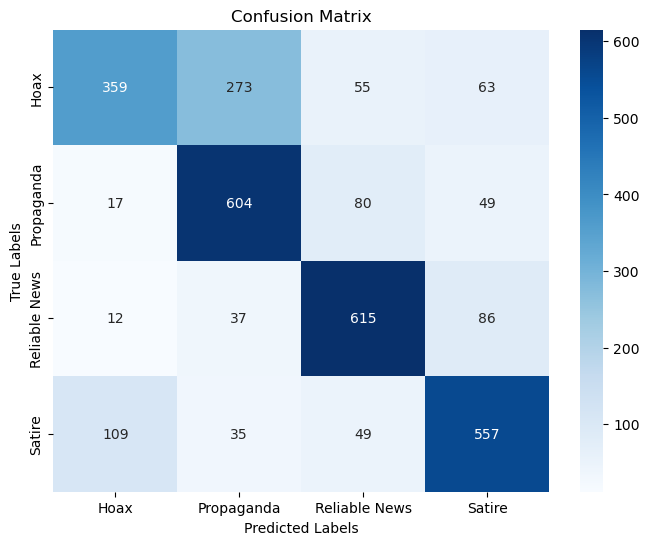

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


conf_matrix = confusion_matrix(y_test_encoded, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()